In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd 
import math
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import noisereduce as nr

import warnings
warnings.filterwarnings("ignore")

In [3]:
feature_audio = "bachao.wav"
nfft = 1103
(Rsr,sig) = wav.read(feature_audio)
print("Re-sampled Rate :", Rsr)
mfcc_feat = mfcc(sig, Rsr, nfft=nfft)
fbank_feat = logfbank(sig, Rsr, nfft=nfft)

Re-sampled Rate : 16000


In [4]:
print(len(mfcc_feat[:,:]))

299


### MFCC Features

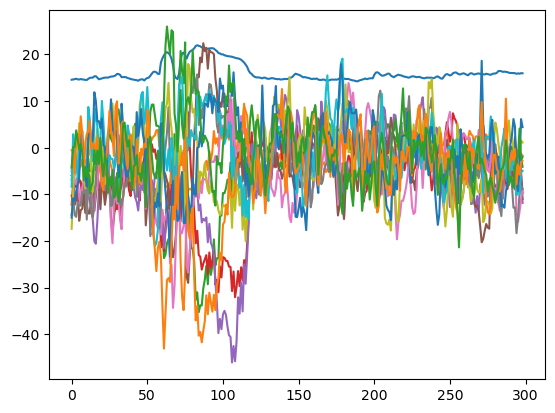

In [5]:
plt.plot(mfcc_feat)
plt.show()

In [6]:
print(fbank_feat[:1,:])

[[ 7.2793479   9.10964122 10.68287358 11.2910332  10.96601765 10.36564814
  10.85280097 10.98395034 11.54316004 11.67303505 11.57786993 11.03478412
  11.6462347  10.7313739  11.49152377 11.09097915 11.030583   11.91314964
  11.09356039 11.32713    10.80395634 10.90977719 11.60984339 12.16479421
  12.04137869 11.80271641]]


### FilterBank Features

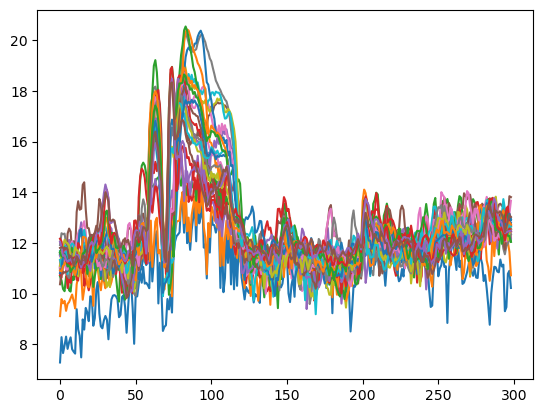

In [7]:
plt.plot(fbank_feat)
plt.show()

These graphical representation doesn't tell us anything significant unless solely for the purpose of debugging. These features really signify something when they are put forward for the use of any specific task usually classification.

In [8]:
audio, sr = librosa.load(feature_audio, mono=True)

In [9]:
print("Original Sample Rate : ", sr)

Original Sample Rate :  22050


In [10]:
ipd.Audio(audio, rate=sr)

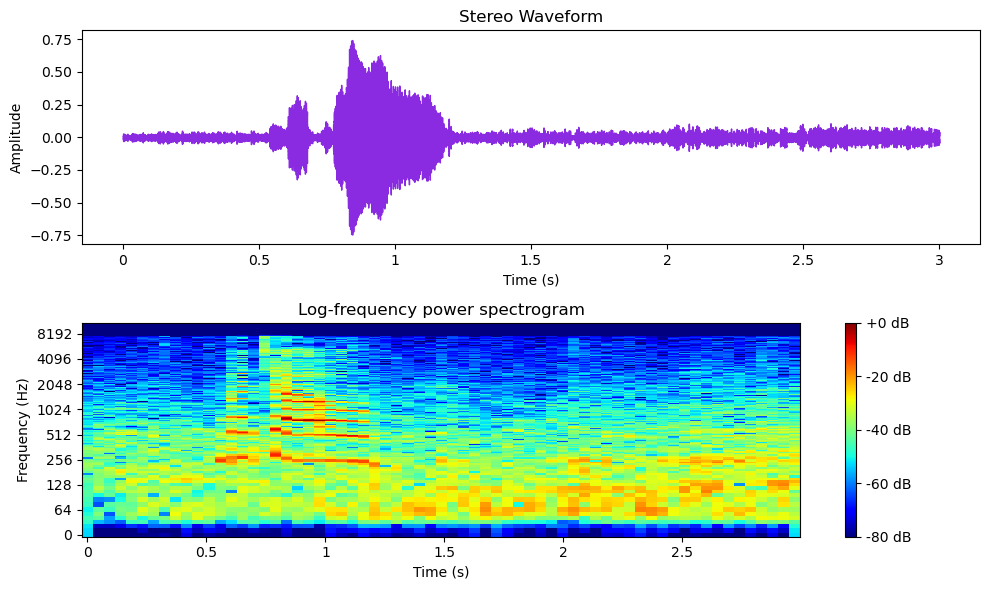

In [11]:
def plot_wavespec(sound, sr, hop_length=1024):
    # Plot Waveform
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(sound, sr=sr, color="blueviolet")
    plt.title('Stereo Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sound, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time', cmap='jet')
    plt.colorbar(format="%+2.f dB")
    plt.title('Log-frequency power spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

plot_wavespec(audio, sr)

### Separating audio keyword as foreground and environment as background using Non-Negative Matrix Factorization (NMF)

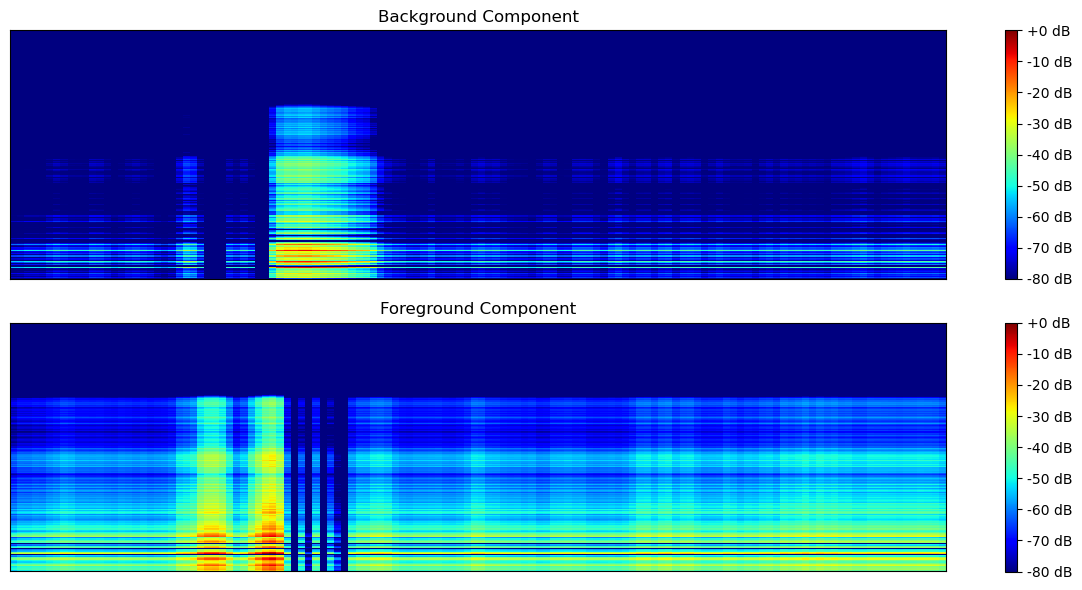

In [12]:
def display_nmf_components(sound, sr, n_components=2, hop_length=512):
    # Compute the magnitude spectrogram
    D = np.abs(librosa.stft(sound, hop_length=hop_length))

    # Decompose the spectrogram using NMF 
    # V = W•H
    # W = Components Matrix or basis vectors, H = Activation Matrix or coefficients corresponding to each component
    components, activations = librosa.decompose.decompose(D, n_components=n_components, sort=True)

    # Reconstruct the background and foreground components
    background = components[:, :1] @ activations[:1, :]
    foreground = components[:, 1:] @ activations[1:, :]
    reconstructed = background + foreground
    bg_audio = librosa.istft(background, hop_length=hop_length)
    fg_audio = librosa.istft(background, hop_length=hop_length)
    rec_audio = librosa.istft(reconstructed, hop_length=hop_length)

    # Plot background component
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(background, ref=np.max), sr=sr, hop_length=hop_length, cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Background Component')

    # Plot foreground component
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(foreground, ref=np.max), sr=sr, hop_length=hop_length, cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Foreground Component')

    plt.tight_layout()
    plt.show()
    return bg_audio, fg_audio, rec_audio
    
bg_audio, fg_audio, rec_audio = display_nmf_components(audio, sr)

Background component of signal

In [13]:
ipd.Audio(bg_audio, rate=sr)

Foreground component of signal

In [14]:
ipd.Audio(fg_audio, rate=sr)

Reconstructed Audio signal

In [15]:
ipd.Audio(rec_audio, rate=sr)

## Using NoiseReduce - Python Library to get the desired speech signal from recording and thereafter separating it to get the noise

can implement sequential noise processing : original signal -> non-stationary -> stationary -> desired signal -> noise separation

In [16]:
# Stationary NR technique
s_signal= nr.reduce_noise(y = audio, sr=sr, n_std_thresh_stationary=1.5,stationary=True)

In [17]:
# Non-Stationary NR technique
# s_signal = nr.reduce_noise(y = audio, sr=sr, thresh_n_mult_nonstationary=2,stationary=False)

In [18]:
ipd.Audio(s_signal, rate=sr)

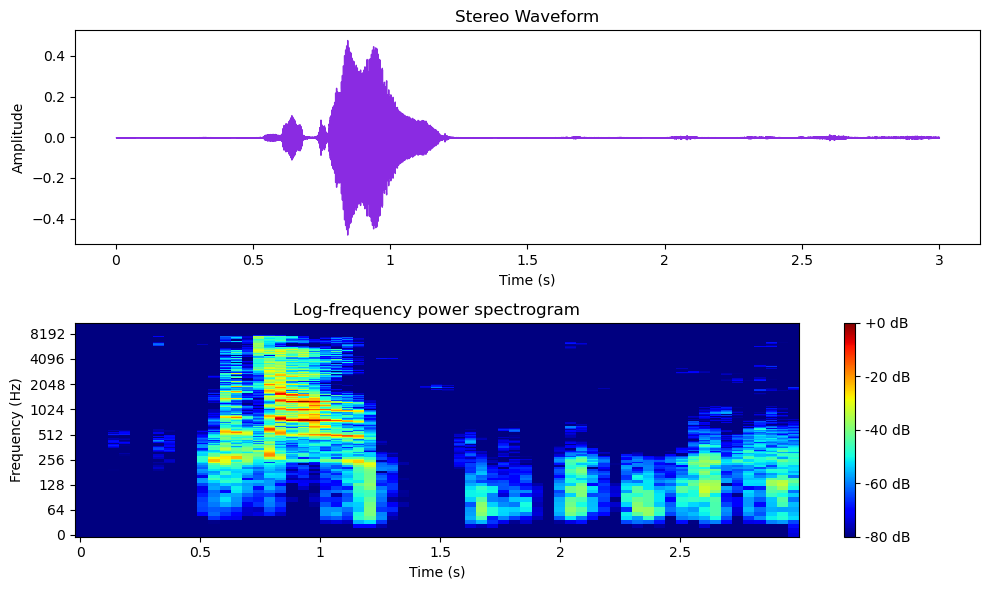

In [19]:
plot_wavespec(s_signal, sr)

Noise reduced signal already looks a little sparse in spectrogram, therefore we'll be using it for further noise separation
We can separate noise by subtracting spectograms and normalizing it and even apply the power law
or We can simply subtract the audio-variables :)

In [20]:
def separate_noise_mask(original_audio, noise_reduced_audio, window_size=2048, hop_length=256):

  original_spectrogram = librosa.stft(original_audio, n_fft=window_size, hop_length=hop_length)
  reduced_spectrogram = librosa.stft(noise_reduced_audio, n_fft=window_size, hop_length=hop_length)
  minimum_value = 1e-6
  reduced_spectrogram = np.maximum(reduced_spectrogram, minimum_value)
  
  noise_estimate = np.abs(original_spectrogram) - np.abs(reduced_spectrogram)

  noise_mask = noise_estimate / np.max(noise_estimate, axis=0, keepdims=True)

  noise_audio = librosa.istft(noise_mask, hop_length=hop_length)

  return noise_audio

noise = separate_noise_mask(audio, s_signal)

In [21]:
# assert len(audio) == len(s_signal), "Audio signals must have the same length"
# noise = audio - s_signal

In [22]:
ipd.Audio(noise, rate=sr)